In [1]:
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
## to convert unix timestamp into readable date

class io:
    def is_file_like(obj) -> bool:
        if not (hasattr(obj, "read") or hasattr(obj, "write")):
            return False

        if not hasattr(obj, "__iter__"):
            return False

        return True
    

def read_ibi_file(file) -> pd.DataFrame:
    if io.is_file_like(file):
        file_to_read = file

    elif isinstance(file, str):
        file_to_read = open(file, 'br')
        close_file = True
    else:
        raise ValueError("Not a valid Input : %d" % type(file))

    initial_pos = file_to_read.tell()
    timestamp = float(str(file_to_read.readline(), 'utf-8').strip().split(',')[0])
    file_to_read.seek(initial_pos)
    ibi = pd.read_csv(file_to_read, skiprows=1, names = ['ibi'], index_col=0)
    ibi['ibi'] *= 1000
    ibi.index = pd.to_datetime((ibi.index * 1000 + timestamp * 1000).map(int), unit='ms', utc = True)
    ibi.index.name = 'datetime'

    if close_file:
        file_to_read.close()
    return ibi

In [3]:
df = read_ibi_file('IBI.csv')
df

,ibi
datetime,
2021-06-23 12:02:12+00:00,625.000
2021-06-23 12:02:12.625000+00:00,625.000
2021-06-23 12:02:13.234000+00:00,609.375
2021-06-23 12:02:13.859000+00:00,625.000
2021-06-23 12:02:14.453000+00:00,593.750
...,...
2021-06-24 01:23:59.109000+00:00,703.125
2021-06-24 01:23:59.796000+00:00,687.500
2021-06-24 01:24:00.468000+00:00,671.875


In [4]:
import preprocessing as pp

In [26]:
hrv_features = pp.get_hrv_features(df['ibi'], 180, 1, ["td"], 0.1, clean_data = True, num_cores= 0)

HRV features: 100%|██████████| 47931/47931 [01:36<00:00, 495.98it/s]


In [27]:
hrv_features

,num_ibis,hrv_mean_nni,hrv_median_nni,hrv_range_nni,hrv_sdsd,hrv_rmssd,hrv_nni_50,hrv_pnni_50,hrv_nni_20,hrv_pnni_20,hrv_cvsd,hrv_sdnn,hrv_cvnni,hrv_mean_hr,hrv_min_hr,hrv_max_hr,hrv_std_hr
datetime,,,,,,,,,,,,,,,,,
2021-06-23 12:05:12+00:00,137,681.113139,687.500,140.625,26.862579,26.863562,5.0,3.649635,49.0,35.766423,0.039441,31.396414,0.046096,88.284321,81.702128,101.052632,4.215523
2021-06-23 12:05:13+00:00,137,681.797445,687.500,140.625,27.094247,27.096439,5.0,3.649635,51.0,37.226277,0.039743,30.721397,0.045059,88.187250,81.702128,101.052632,4.119680
2021-06-23 12:05:14+00:00,136,682.904412,687.500,140.625,27.317267,27.329279,5.0,3.676471,51.0,37.500000,0.040019,29.835926,0.043690,88.033272,81.702128,101.052632,3.988450
2021-06-23 12:05:15+00:00,137,683.280109,687.500,140.625,27.096196,27.096439,5.0,3.649635,51.0,37.226277,0.039656,28.829990,0.042194,87.972287,81.702128,101.052632,3.827081
2021-06-23 12:05:16+00:00,136,683.938419,687.500,140.625,27.194395,27.196611,5.0,3.676471,51.0,37.500000,0.039765,28.270388,0.041335,87.881228,81.702128,101.052632,3.747981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-24 01:23:58+00:00,253,707.571640,703.125,250.000,29.821266,29.822297,8.0,3.162055,81.0,32.015810,0.042147,28.450870,0.040209,84.929107,67.368421,93.658537,3.307242
2021-06-24 01:23:59+00:00,253,707.386364,703.125,250.000,29.821266,29.822297,8.0,3.162055,81.0,32.015810,0.042158,28.530304,0.040332,84.952127,67.368421,93.658537,3.317317
2021-06-24 01:24:00+00:00,254,707.185039,703.125,250.000,29.827052,29.828075,8.0,3.149606,82.0,32.283465,0.042179,28.451294,0.040232,84.975559,67.368421,93.658537,3.307704


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7647f09190>],
      dtype=object)

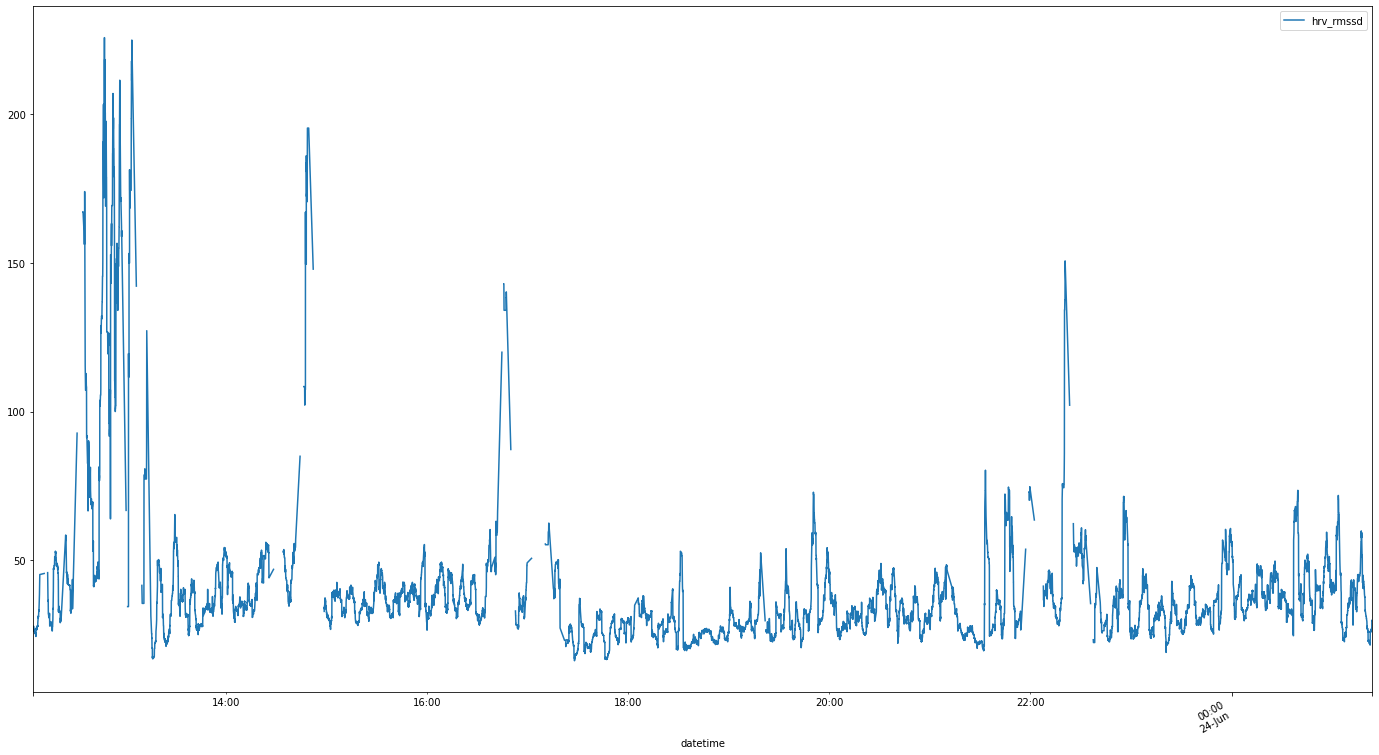

In [40]:
hrv_features[['hrv_rmssd']].plot(subplots=True, figsize=(24,14 ))


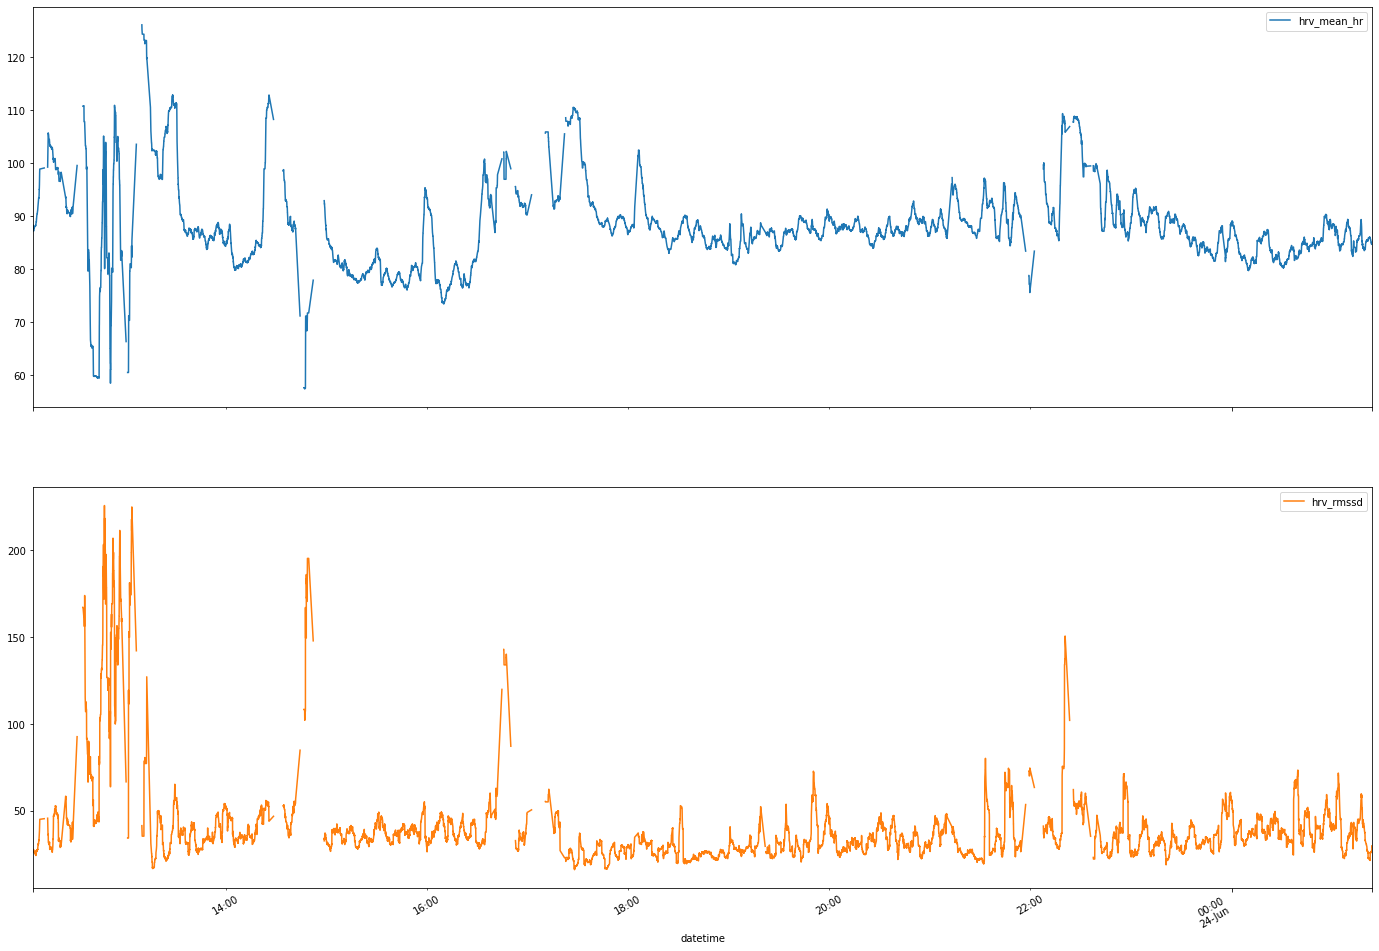

In [41]:
_ = hrv_features[['hrv_mean_hr', 'hrv_rmssd']].plot(subplots=True, figsize=(24, 18))


In [30]:
def lagoption(option, window_size, shift) -> pd.DataFrame:
    """
    option : if we want a lagging / leading or a centered window
    window size : the size of the window we need to specify w.r.t timeinterval
    shift : how much can the data shift for the lagging/ leading and centered window
    """
    if option == "trailing":
        shift = -(shift)
    elif option == "leading":
        shift = +(shift)
    elif option == "centered":
        return (hrv_features['hrv_rmssd'].rolling(window_size, center = True).mean())
    return (hrv_features['hrv_rmssd'].rolling(window_size).mean().shift(shift))


Text(0.5, 1.0, 'window size is 300 seconds with the shift of 10')

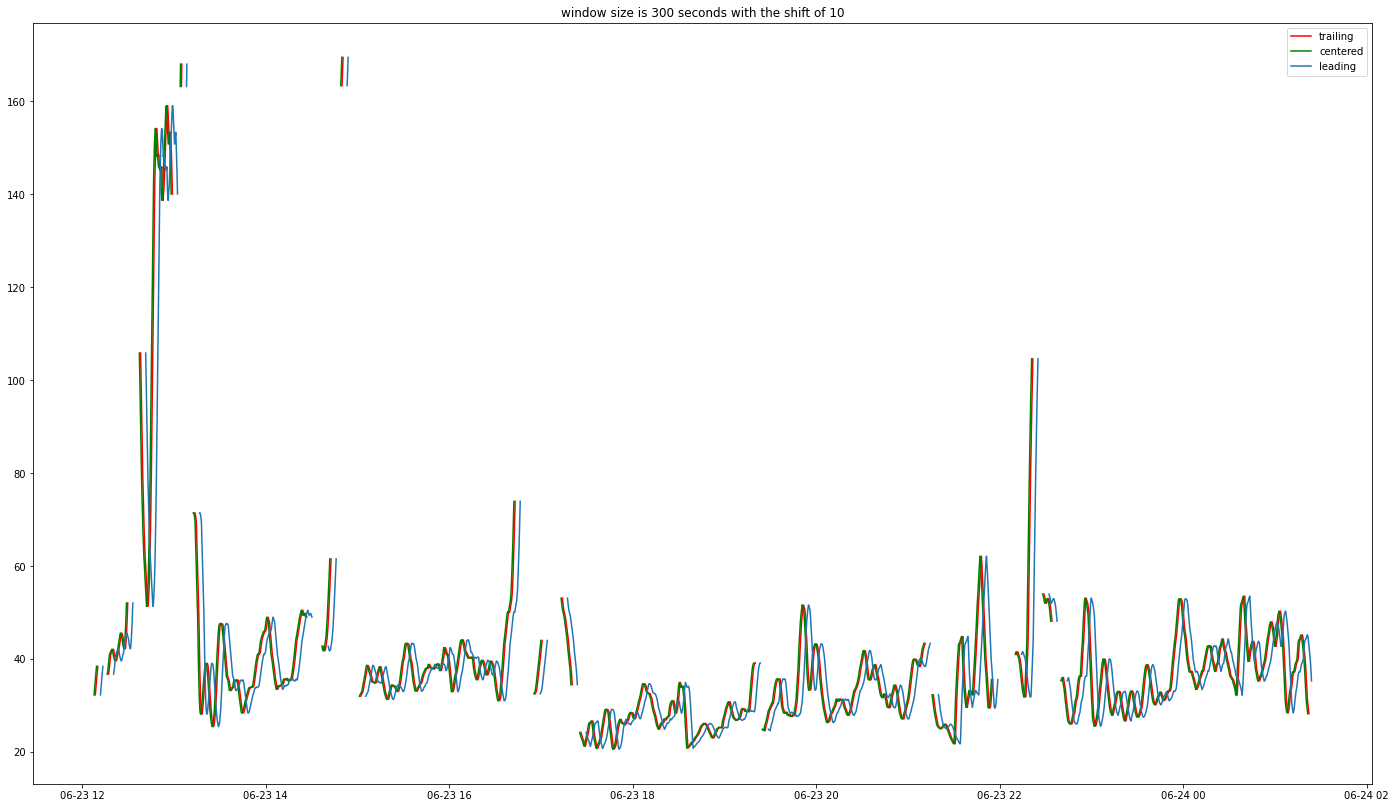

In [54]:
ibi_1 = lagoption("centered", 300, 0)
ibi_2 = lagoption('trailing', 300, 100)
ibi_3 = lagoption('leading', 300, 100)

plt.figure(figsize=(24, 14))
plt.plot(ibi_2, color = 'red')
plt.plot( ibi_1, color='green')
plt.plot( ibi_3)
plt.legend(['trailing', 'centered', 'leading'])
plt.title('window size is 300 seconds with the shift of 10')
